In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from matplotlib.pyplot import figure
from astropy.io import fits
from astropy.table import Table

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import QTable

filename_path = '../data/astraAllStarASPCAP-0.7.fits'

# this function is Lucy's way to get rid of columns that are more than 1D (pandas doesn't support that)
def Table_to_pandas(fn):
    data = fits.open(fn)
    df = QTable(data[2].data)
    cols = []
    cols_drop = []
    for i in df.columns:
        if np.size(df[i][0])==1:
            cols.append(i)
        else:
            cols_drop.append(i)
    print(cols_drop)
    return df[cols].to_pandas()

df_sdss5 = Table_to_pandas(filename_path)

df_sdss5 = df_sdss5[(df_sdss5['teff']>4500) & (df_sdss5['teff']<6500)]
df_sdss5 = df_sdss5[(df_sdss5['snr']>=200)]

['sdss5_target_flags']


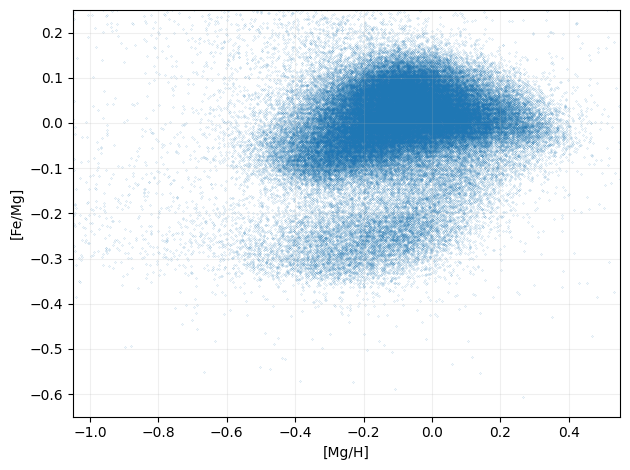

In [2]:
# Just taking a look

df_sdss5['fe_mg'] = df_sdss5['fe_h'] - df_sdss5['mg_h']

plt.scatter(df_sdss5['mg_h'], df_sdss5['fe_mg'], s = 0.01)
plt.grid('True', alpha = 0.2)
plt.xlabel('[Mg/H]')
plt.ylabel('[Fe/Mg]')
plt.ylim(-0.65,0.25)
plt.xlim(-1.05,0.55)
plt.tight_layout()

In [3]:
# -------------------------------
# 1. SDSS cut on Fe/H error
# -------------------------------
df_sdss5 = df_sdss5[df_sdss5['gaia_dr3_source_id'] > 0]
df_sdss_metcut = df_sdss5[(df_sdss5['e_fe_h'] < 0.1) & (df_sdss5['e_mg_h'] < 0.1)]

In [4]:
dupes_gaia = df_sdss_metcut[df_sdss_metcut['gaia_dr3_source_id'].duplicated(keep=False)]

star_1 = dupes_gaia[dupes_gaia['gaia_dr3_source_id'] == 2972348717247487360]
star_2 = dupes_gaia[dupes_gaia['gaia_dr3_source_id'] == 2994228345805983232]
star_3 = dupes_gaia[dupes_gaia['gaia_dr3_source_id'] == 2432070586214757376]

In [5]:
print(star_1['snr'])
print(star_1['fe_h'])
print(star_1['e_fe_h'])

106019    342.693634
106020    271.557587
Name: snr, dtype: float32
106019   -0.268
106020   -0.245
Name: fe_h, dtype: float32
106019    0.001
106020    0.001
Name: e_fe_h, dtype: float32


In [6]:
print(star_2['snr'])
print(star_2['fe_h'])
print(star_2['e_fe_h'])

143985    206.863419
143986    783.233887
Name: snr, dtype: float32
143985    0.096
143986    0.104
Name: fe_h, dtype: float32
143985    0.002
143986    0.002
Name: e_fe_h, dtype: float32


In [7]:
print(star_3['snr'])
print(star_3['fe_h'])
print(star_3['e_fe_h'])

1546130    257.379181
1546131    373.817047
Name: snr, dtype: float32
1546130    0.068
1546131    0.065
Name: fe_h, dtype: float32
1546130    0.002
1546131    0.002
Name: e_fe_h, dtype: float32


In [8]:
# Ensure unique SDSS rows per Gaia source
df_sdss_metcut = df_sdss_metcut.sort_values(['snr'], ascending=False)
df_sdss_metcut = df_sdss_metcut.drop_duplicates(subset='gaia_dr3_source_id', keep='first')

In [53]:
df_sdss_metcut[df_sdss_metcut['gaia_dr3_source_id'] == 2972348717247487360]['snr']

106019    342.693634
Name: snr, dtype: float32

In [54]:
df_sdss_metcut[df_sdss_metcut['gaia_dr3_source_id'] == 2994228345805983232]['snr']

143986    783.233887
Name: snr, dtype: float32

In [55]:
df_sdss_metcut[df_sdss_metcut['gaia_dr3_source_id'] == 2432070586214757376]['snr']

1546131    373.817047
Name: snr, dtype: float32

In [ ]:

# Ensure unique SDSS rows per Gaia source
df_sdss_metcut = df_sdss_metcut.sort_values(['e_fe_h', 'e_mg_h']) \
                               .drop_duplicates(subset='gaia_dr3_source_id', keep='first')

# -------------------------------
# 2. Save Gaia IDs from SDSS cut (optional)
# -------------------------------
df_sdss_metcut['gaia_dr3_source_id'].to_csv('data/gaia_ids_from_sdss.txt', index=False, header=False)

# -------------------------------
# 3. Gaia RVS flags / high SNR selection
# -------------------------------
df_gaia_rvs_flags = pd.read_csv("data/gaia_rvs_flags.csv")

# Keep only sources with RV spectra
df_gaia_has_rvs = df_gaia_rvs_flags[df_gaia_rvs_flags['has_rvs'] == True]

# High SNR spectra
df_gaia_high_snr = df_gaia_has_rvs[df_gaia_has_rvs['rvs_spec_sig_to_noise'] > 100]

# Optional: save high SNR source_ids to VOTable
t = Table()
t['source_id'] = df_gaia_high_snr['source_id'].values
t.write('data/gaia_high_snr_source_ids.vot', format='votable', overwrite=True)

# -------------------------------
# 4. Filter Gaia spectra to only those in SDSS cut
# -------------------------------
stars_gaia_spectra = rvs_1_df[['datalinkID', 'flux', 'flux_error']].copy()
stars_gaia_spectra['source_id'] = stars_gaia_spectra['datalinkID']

# Only keep spectra for SDSS stars with e_fe_h < 0.1
sdss_source_ids = set(df_sdss_metcut['gaia_dr3_source_id'])
stars = stars_gaia_spectra[stars_gaia_spectra['source_id'].isin(sdss_source_ids)].copy()
stars = stars.reset_index(drop=True)

# -------------------------------
# 5. Attach SDSS metadata safely
# -------------------------------
meta_cols = ['teff', 'e_teff', 'logg', 'e_logg', 'fe_h', 'e_fe_h',
             'o_h', 'e_o_h', 'mg_h', 'e_mg_h', 'si_h', 'e_si_h']

# Map SDSS values to Gaia spectra using source_id
for col in meta_cols:
    stars[col] = stars['source_id'].map(
        df_sdss_metcut.set_index('gaia_dr3_source_id')[col]
    )

# -------------------------------
# 6. Drop duplicate columns if any (optional)
# -------------------------------
#stars = stars.drop(columns=['datalinkID'], errors='ignore')

# Now 'stars' contains:
# - only Gaia spectra corresponding to SDSS stars with e_fe_h < 0.1
# - attached SDSS metadata (Teff, Fe/H, logg, alpha elements, etc.)


OSError: Cannot save file into a non-existent directory: 'data'